In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy import interpolate
import math
import pickle
import classy 

matplotlib.rcParams['axes.linewidth'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.labelsize'] = 75
matplotlib.rcParams['xtick.labelsize'] = 65 
matplotlib.rcParams['ytick.labelsize'] = 65
matplotlib.rcParams['legend.fontsize'] = 150
matplotlib.rcParams['axes.labelpad'] = 100

In [2]:
!pip show classy

Name: classy
Version: 2.8.2
Summary: Python interface to the Cosmological Boltzmann code CLASS
Home-page: http://www.class-code.net
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /Users/alexreeves/Desktop/MastersThesis/masters-env/lib/python3.10/site-packages
Requires: 
Required-by: 


In [3]:
# fn_006 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_6/ede_mnu006.bestfit'
# fn_012 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_6/ede_mnu012.bestfit'
# fn_018 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_5/ede_mnu018.bestfit'
# fn_024 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_5/ede_mnu024.bestfit'
# fn_03 = '/cluster/home/areeves/MastersThesis/chi2_analysis/best_fit_files/minuit_minimiser/run_5/ede_mnu03.bestfit'

In [4]:
fn_006 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_006_Ivanov.bestfit'
fn_009 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_009_Ivanov.bestfit'
fn_012 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_012_Ivanov.bestfit'
fn_015 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_015_Ivanov.bestfit'
fn_018 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_018_Ivanov.bestfit'
fn_024 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_024_Ivanov.bestfit'
fn_03 = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_03_Ivanov.bestfit'



In [5]:
fn_lcdm = '/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_29_minimize_al_LCDM_Ivanov.bestfit'

bfs_dict={}

In [6]:
#save the lcdm data in a dictionary 

with open(fn_lcdm) as f:
    bfs_dict['lcdm'] = {}
    for line in f: 
        if line.split()[0] == '#':
            print(len(line.split()))
            names = [line.split()[k].replace(',', '') for k in range(1,62)]
        else: 
            vals = line.split()

    print(len(names))
    print(len(vals))
    for j in range(len(vals)):
        bfs_dict['lcdm'][names[j]] = vals[j]


62
61
61


In [7]:
# fns = [fn_006,fn_012,fn_018,fn_024,fn_03]
# mnus= [6,12,18,24,30]

fns = [fn_006,fn_009,fn_012,fn_015,fn_018,fn_024,fn_03]
mnus= [6,9,12,15,18,24,30]


In [8]:
i=0
for fn in fns: 
    print(fn)
    with open(fn) as f:
        bfs_dict[f'{mnus[i]}'] = {}
        for line in f: 
            if line.split()[0] == '#':
                print(len(line.split()))
                names = [line.split()[k].replace(',', '') for k in range(1,65)]
            else: 
                vals = line.split()

        print(len(names))
        print(len(vals))
        for j in range(len(vals)):
            bfs_dict[f'{mnus[i]}'][names[j]] = vals[j]

    i+=1

/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_006_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_009_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_012_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_015_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_018_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_024_Ivanov.bestfit
65
64
64
/Users/alexreeves/Desktop/MastersThesis/chi2_analysis/best_fit_files/final_bf_files/2022_03_30_minimize_al_03_Ivanov.bestfit
65
64
64


In [9]:
print(classy.__file__)

/Users/alexreeves/Desktop/MastersThesis/masters-env/lib/python3.10/site-packages/classy.cpython-310-darwin.so


### In this notebook the position of the first BAO peak is compared for different $m_\nu$ models 

In [10]:
#function for loading in bestfit data 
def load_obj(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)
    

In [11]:
#be careful with scales- from param file only omega_b needs to be altered 
# mnu_006_dict= load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu006')
# mnu_012_dict=load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/ede_mnu012')
# mnu_018_dict=load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu018')
# mnu_024_dict = load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu024')
# mnu_03_dict= load_obj('/cluster/home/areeves/MastersThesis/analysis_notebooks/best_fit_data/mnu03')

mnu_006_dict= bfs_dict['6']
mnu_012_dict= bfs_dict['12']
mnu_018_dict= bfs_dict['18']
mnu_024_dict= bfs_dict['24']
mnu_03_dict= bfs_dict['30']
mnu_015_dict= bfs_dict['15']
mnu_009_dict= bfs_dict['9']
lcdm_dict = bfs_dict['lcdm']

print(mnu_006_dict.keys())

dict_keys(['omega_b', 'omega_cdm', '100*theta_s', 'ln10^{10}A_s', 'n_s', 'tau_reio', 'fEDE', 'log10z_c', 'thetai_scf', 'A_cib_217', 'xi_sz_cib', 'A_sz', 'ps_A_100_100', 'ps_A_143_143', 'ps_A_143_217', 'ps_A_217_217', 'ksz_norm', 'gal545_A_100', 'gal545_A_143', 'gal545_A_143_217', 'gal545_A_217', 'galf_TE_A_100', 'galf_TE_A_100_143', 'galf_TE_A_100_217', 'galf_TE_A_143', 'galf_TE_A_143_217', 'galf_TE_A_217', 'calib_100T', 'calib_217T', 'A_planck', 'b^{(1)}_1', 'b^{(1)}_2', 'b^{(1)}_{G_2}', 'c^{(1)}_{0}', 'c^{(1)}_{2}', 'P^{(1)}_{shot}', 'b^{(1)}_4', 'b^{(2)}_1', 'b^{(2)}_2', 'b^{(2)}_{G_2}', 'c^{(2)}_{0}', 'c^{(2)}_{2}', 'P^{(2)}_{shot}', 'b^{(2)}_4', 'b^{(3)}_1', 'b^{(3)}_2', 'b^{(3)}_{G_2}', 'c^{(3)}_{0}', 'c^{(3)}_{2}', 'P^{(3)}_{shot}', 'b^{(3)}_4', 'b^{(4)}_1', 'b^{(4)}_2', 'b^{(4)}_{G_2}', 'c^{(4)}_{0}', 'c^{(4)}_{2}', 'P^{(4)}_{shot}', 'b^{(4)}_4', 'z_reio', 'Omega_m', 'YHe', 'H0', 'A_s', 'sigma8'])


In [12]:
#find the interesting physical densities

def get_phys_densities(dict):
    H_0 = float(dict['H0'])
    fac = (H_0/100)**2
    Omega_m = float(dict['Omega_m'])
    Omega_lam = 1-Omega_m
    om = Omega_m * fac 
    ol = Omega_lam*fac
    
    return om, ol 
    
    
print(get_phys_densities(mnu_006_dict))
print(get_phys_densities(mnu_024_dict))


(0.15037448270315612, 0.3407667610329339)
(0.15658980246641582, 0.3349341606248743)


In [13]:
#BEST FIT PARAMS FROM BF with LCDM model 
#TT,TE,EE +lowE -> switch to this + BAO 
LCDM_settings = {'output':'tCl pCl lCl mPk', 
                 '100*theta_s': lcdm_dict['100*theta_s'],
                 'ln10^{10}A_s': lcdm_dict['ln10^{10}A_s'],
                 'n_s': lcdm_dict['n_s'],
                 'omega_b':  float(lcdm_dict['omega_b']),
                 'omega_cdm': lcdm_dict['omega_cdm'],
                 'tau_reio': lcdm_dict['tau_reio'],
                 'l_max_scalars':3508,
                 'non linear':'HMcode',
                 'P_k_max_h/Mpc':30,
                 'Omega_Lambda':0,                      
                 'Omega_fld':0,                         
                 'Omega_scf': -1,                        #scf
                 'scf_parameters':'1, 1, 1, 1, 1, 0.0', #scf
                 'scf_tuning_index':3,                  #scf
                 'attractor_ic_scf':'no',               #scf
                 'n_scf':3,                             #scf
                 'CC_scf':1,                            #scf
                 'f_scf': np.power(10,26.59913),        #scf                              
                 'm_scf': 0,                            #scf: this guarantees fEDE is 0 (otherwise hard to force)
                 'thetai_scf': 2.83,        
                 'z_max_pk':2.}

In [14]:
LCDM = Class()
LCDM.set(LCDM_settings)
LCDM.compute()

print(LCDM.fEDE())

0.0


In [15]:
EDE_pp_params= {'100*theta_s': mnu_006_dict['100*theta_s'],
         'log10z_c': mnu_006_dict['log10z_c'],
         'thetai_scf': mnu_006_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_006_dict['ln10^{10}A_s'],
         'n_s': mnu_006_dict['n_s'],
         'omega_b':  float(mnu_006_dict['omega_b']),
         'omega_cdm': mnu_006_dict['omega_cdm'],
         'tau_reio': mnu_006_dict['tau_reio'],
         'fEDE': mnu_006_dict['fEDE'],
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.}

EDE_mnu024_006bfparams= {'100*theta_s': mnu_006_dict['100*theta_s'],
         'log10z_c': mnu_006_dict['log10z_c'],
         'thetai_scf': mnu_006_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_006_dict['ln10^{10}A_s'],
         'n_s': mnu_006_dict['n_s'],
         'omega_b':  float(mnu_006_dict['omega_b']),
         'omega_cdm': mnu_006_dict['omega_cdm'],
         'tau_reio': mnu_006_dict['tau_reio'],
         'fEDE': mnu_006_dict['fEDE'],
         'N_ncdm':1,
         'm_ncdm': 0.24,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.}


EDE_mnu024_024bfparams= {'100*theta_s': mnu_006_dict['100*theta_s'],
         'log10z_c': mnu_006_dict['log10z_c'],
         'thetai_scf': mnu_006_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_006_dict['ln10^{10}A_s'],
         'n_s': mnu_006_dict['n_s'],
         'omega_b':  float(mnu_006_dict['omega_b']),
         'omega_cdm': mnu_024_dict['omega_cdm'],
         'tau_reio': mnu_006_dict['tau_reio'],
         'fEDE': mnu_006_dict['fEDE'],
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.}


EDE_mnu024_raisefedeparams= {'100*theta_s': mnu_006_dict['100*theta_s'],
         'log10z_c': mnu_006_dict['log10z_c'],
         'thetai_scf': mnu_006_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_006_dict['ln10^{10}A_s'],
         'n_s': mnu_006_dict['n_s'],
         'omega_b':  float(mnu_006_dict['omega_b']),
         'omega_cdm': mnu_024_dict['omega_cdm'],
         'tau_reio': mnu_006_dict['tau_reio'],
         'fEDE': mnu_024_dict['fEDE'],
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.}

In [16]:
EDE_pp = Class()
EDE_pp.set(EDE_pp_params)
EDE_pp.compute()

In [17]:
EDE_mnu024_024bf = Class()
EDE_mnu024_024bf.set(EDE_mnu024_024bfparams)
EDE_mnu024_024bf.compute()

In [18]:
EDE_mnu024_raisefede = Class()
EDE_mnu024_raisefede.set(EDE_mnu024_raisefedeparams)
EDE_mnu024_raisefede.compute()

In [19]:
EDE_mnu024_006bf = Class()
EDE_mnu024_006bf.set(EDE_mnu024_006bfparams)
EDE_mnu024_006bf.compute()

In [20]:
print(dir(EDE_mnu024_006bf))

['Hubble', 'Neff', 'Om_m', 'Omega0_cdm', 'Omega0_k', 'Omega0_m', 'Omega_Lambda', 'Omega_b', 'Omega_g', 'Omega_m', 'Omega_nu', 'Omega_r', 'T_cmb', '__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '_check_task_dependency', '_fillparfile', '_pars_check', 'age', 'angular_distance', 'baryon_temperature', 'compute', 'density_cl', 'empty', 'fEDE', 'get_background', 'get_current_derived_parameters', 'get_fsigma8', 'get_perturbations', 'get_pk', 'get_pk_and_k_and_z', 'get_pk_array', 'get_pk_cb', 'get_pk_cb_array', 'get_pk_cb_lin', 'get_pk_lin', 'get_pk_mult', 'get_primordial', 'get_thermodynamics', 'get_transfer', 'h', 'initialize_output', 'ionization_fraction', 'lensed_cl', 'log10f_scf', 'log10m_scf

In [21]:
print(EDE_mnu024_006bf.Omega0_m()*EDE_mnu024_006bf.h()**2)
print((1-EDE_mnu024_006bf.Omega0_m())*EDE_mnu024_006bf.h()**2)

0.1523069376119901
0.31724198627296984


In [22]:
#find the interesting physical densities

def get_phys_densities(dict):
    H_0 = float(dict['H0'])
    fac = (H_0/100)**2
    Omega_m = float(dict['Omega_m'])
    Omega_lam = 1-Omega_m
    om = Omega_m * fac 
    ol = Omega_lam*fac
    
    return om, ol 
    
    
print(get_phys_densities(mnu_006_dict))
print(get_phys_densities(mnu_024_dict))

(0.15037448270315612, 0.3407667610329339)
(0.15658980246641582, 0.3349341606248743)


In [23]:
print(EDE_mnu024_024bf.h())
print(EDE_mnu024_006bf.h())
print(EDE_pp.h())

0.6868723
0.6852364
0.7008159


In [24]:
print(EDE_mnu024_024bf.rs_drag())
print(EDE_mnu024_006bf.rs_drag())
print(EDE_pp.rs_drag())

141.91099728575753
142.84827367846304
142.93651023333433


In [25]:
sig8_EDE_mnu024_024bf = EDE_mnu024_024bf.sigma8()
sig8_EDE_mnu024_006bf = EDE_mnu024_006bf.sigma8()
sig8_pp = EDE_pp.sigma8()

print(sig8_pp)
print(sig8_EDE_mnu024_024bf)
print(sig8_EDE_mnu024_006bf)

#COMAPRE WITH BENCHMARK LSS 3X2PT VALUE OF SIGMA8=0.733 FROM DES 

0.8282277953434376
0.840992903457091
0.7872417785022722


In [26]:
rs_lcdm = LCDM.rs_drag()
rs_ede_pp = EDE_pp.rs_drag()
rs_EDE_mnu024_024bf = EDE_mnu024_024bf.rs_drag()
rs_EDE_mnu024_006bf = EDE_mnu024_006bf.rs_drag()

rs_EDE_mnu024_raisefede = EDE_mnu024_raisefede.rs_drag()

print(rs_EDE_mnu024_024bf)
print(rs_EDE_mnu024_006bf)
print(rs_ede_pp)
print(rs_lcdm)
#MUCH SMALLER DECREASE IN R-S THAN EXPECTED! roughly 7% increase in ang diam distance and 5% reduction in r_s --- why s this and what values have we take for parameters! 

141.91099728575753
142.84827367846304
142.93651023333433
147.1725283888452


In [27]:
# #Get background quantities and recover their names:
baLCDM = LCDM.get_background()
baEDE_pp = EDE_pp.get_background()
baEDE_mnu024_024bf = EDE_mnu024_024bf.get_background()
baEDE_mnu024_006bf = EDE_mnu024_006bf.get_background()
baEDE_mnu024_raisefede = EDE_mnu024_raisefede.get_background()

EDE_pp_ang = baEDE_pp['ang.diam.dist.']
LCDM_ang = baLCDM['ang.diam.dist.']
EDE_mnu024_006bf_ang = baEDE_mnu024_006bf['ang.diam.dist.']
EDE_mnu024_024bf_ang = baEDE_mnu024_024bf['ang.diam.dist.']
EDE_mnu024_raisefede_ang = baEDE_mnu024_raisefede['ang.diam.dist.']

z_lcdm = baLCDM['z']
z_ede_pp = baEDE_pp['z']
z_ede_mnu024_024bf = baEDE_mnu024_024bf['z']
z_ede_mnu024_006bf = baEDE_mnu024_006bf['z']
z_ede_mnu024_raisefede = baEDE_mnu024_raisefede['z']

#Form the spherically averaged D_v  
#Made unitless as we look at ratios anyway 
LCDM_dv = ((((np.ones_like(z_lcdm)+z_lcdm)*LCDM_ang)**2)*z_lcdm/baLCDM['H [1/Mpc]'])**(1/3) 
EDE_pp_dv =((((np.ones_like(z_lcdm)+z_ede_pp)*EDE_pp_ang)**2)*z_ede_pp/baEDE_pp['H [1/Mpc]'])**(1/3)
EDE_mnu024_024bf_dv =((((np.ones_like(z_lcdm)+z_ede_mnu024_024bf)*EDE_mnu024_024bf_ang)**2)*z_ede_mnu024_024bf/baEDE_mnu024_024bf['H [1/Mpc]'])**(1/3)
EDE_mnu024_006bf_dv =((((np.ones_like(z_lcdm)+z_ede_mnu024_006bf)*EDE_mnu024_006bf_ang)**2)*z_ede_mnu024_006bf/baEDE_mnu024_006bf['H [1/Mpc]'])**(1/3)
EDE_mnu024_raisefede_dv =((((np.ones_like(z_lcdm)+z_ede_mnu024_raisefede)*EDE_mnu024_raisefede_ang)**2)*z_ede_mnu024_raisefede/baEDE_mnu024_raisefede['H [1/Mpc]'])**(1/3)


EDE_pp_ratios = EDE_pp_dv/rs_ede_pp
LCDM_ratios = LCDM_dv/rs_lcdm
EDE_mnu024_024bf_ratios = EDE_mnu024_024bf_dv/rs_EDE_mnu024_024bf
EDE_mnu024_006bf_ratios = EDE_mnu024_006bf_dv/rs_EDE_mnu024_006bf
EDE_mnu024_raisefede_ratios = EDE_mnu024_raisefede_dv/rs_EDE_mnu024_raisefede


In [28]:
#making an interpolation to match up the z values for different experiments 

EDE_pp_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_pp),np.flip(EDE_pp_ratios))
EDE_mnu024_024bf_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu024_024bf),np.flip(EDE_mnu024_024bf_ratios))
EDE_mnu024_006bf_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu024_006bf),np.flip(EDE_mnu024_006bf_ratios))
EDE_mnu024_raisefede_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu024_raisefede),np.flip(EDE_mnu024_raisefede_ratios))



In [29]:
EDE_pp_out = EDE_pp_spline(z_lcdm)
EDE_mnu024_024bf_out = EDE_mnu024_024bf_spline(z_lcdm)
EDE_mnu024_006bf_out = EDE_mnu024_006bf_spline(z_lcdm)
EDE_mnu024_raisefede_out = EDE_mnu024_raisefede_spline(z_lcdm)

In [30]:
#THE BOSS DATA POINTS: 

rd_fid = 147.78 #MPc (fiducial r_d value used in paper)

boss_zs = [0.38,0.61] #the average redshifts at which the BOSS data is collected 

boss_vals = np.array([1477,2140]) #The average values of D_v * rd_fid/r_d from the BOSS data section 8.2 eqts 21-23 in https://arxiv.org/pdf/1607.03155.pdf

boss_vals = boss_vals/rd_fid

z_038 = np.where((z_lcdm<=0.38) & (z_lcdm>=0.379))[0][0]

# z_051 = np.where((z_lcdm<=0.51) & (z_lcdm>=0.509))[0][0]

z_061 = np.where((z_lcdm<=0.61) & (z_lcdm>=0.609))[0][0]

lcdm_reference_vals = np.array([LCDM_ratios[z_038], LCDM_ratios[z_061]])
boss_ratios = boss_vals/lcdm_reference_vals

print(boss_ratios)

[1.00375075 0.98836493]


## Make interesting d_a plot/r_s -- I think this will be fixed at recombination 

/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_16880/4247567626.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_pp_out*rs_lcdm/(LCDM_dv), label='mnu006')
/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_16880/4247567626.py:6: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_mnu024_024bf_out*rs_lcdm/(LCDM_dv),label='raise omega_cdm')
/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_16880/4247567626.py:7: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_mnu024_006bf_out*rs_lcdm/(LCDM_dv),label='raise m_nu')
/var/folders/pb/qmsvthxs5cv4cnk3lwh2wy180000gn/T/ipykernel_16880/4247567626.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(z_lcdm, EDE_mnu024_raisefede_out*rs_lcdm/(LCDM_dv),label='raisefede')


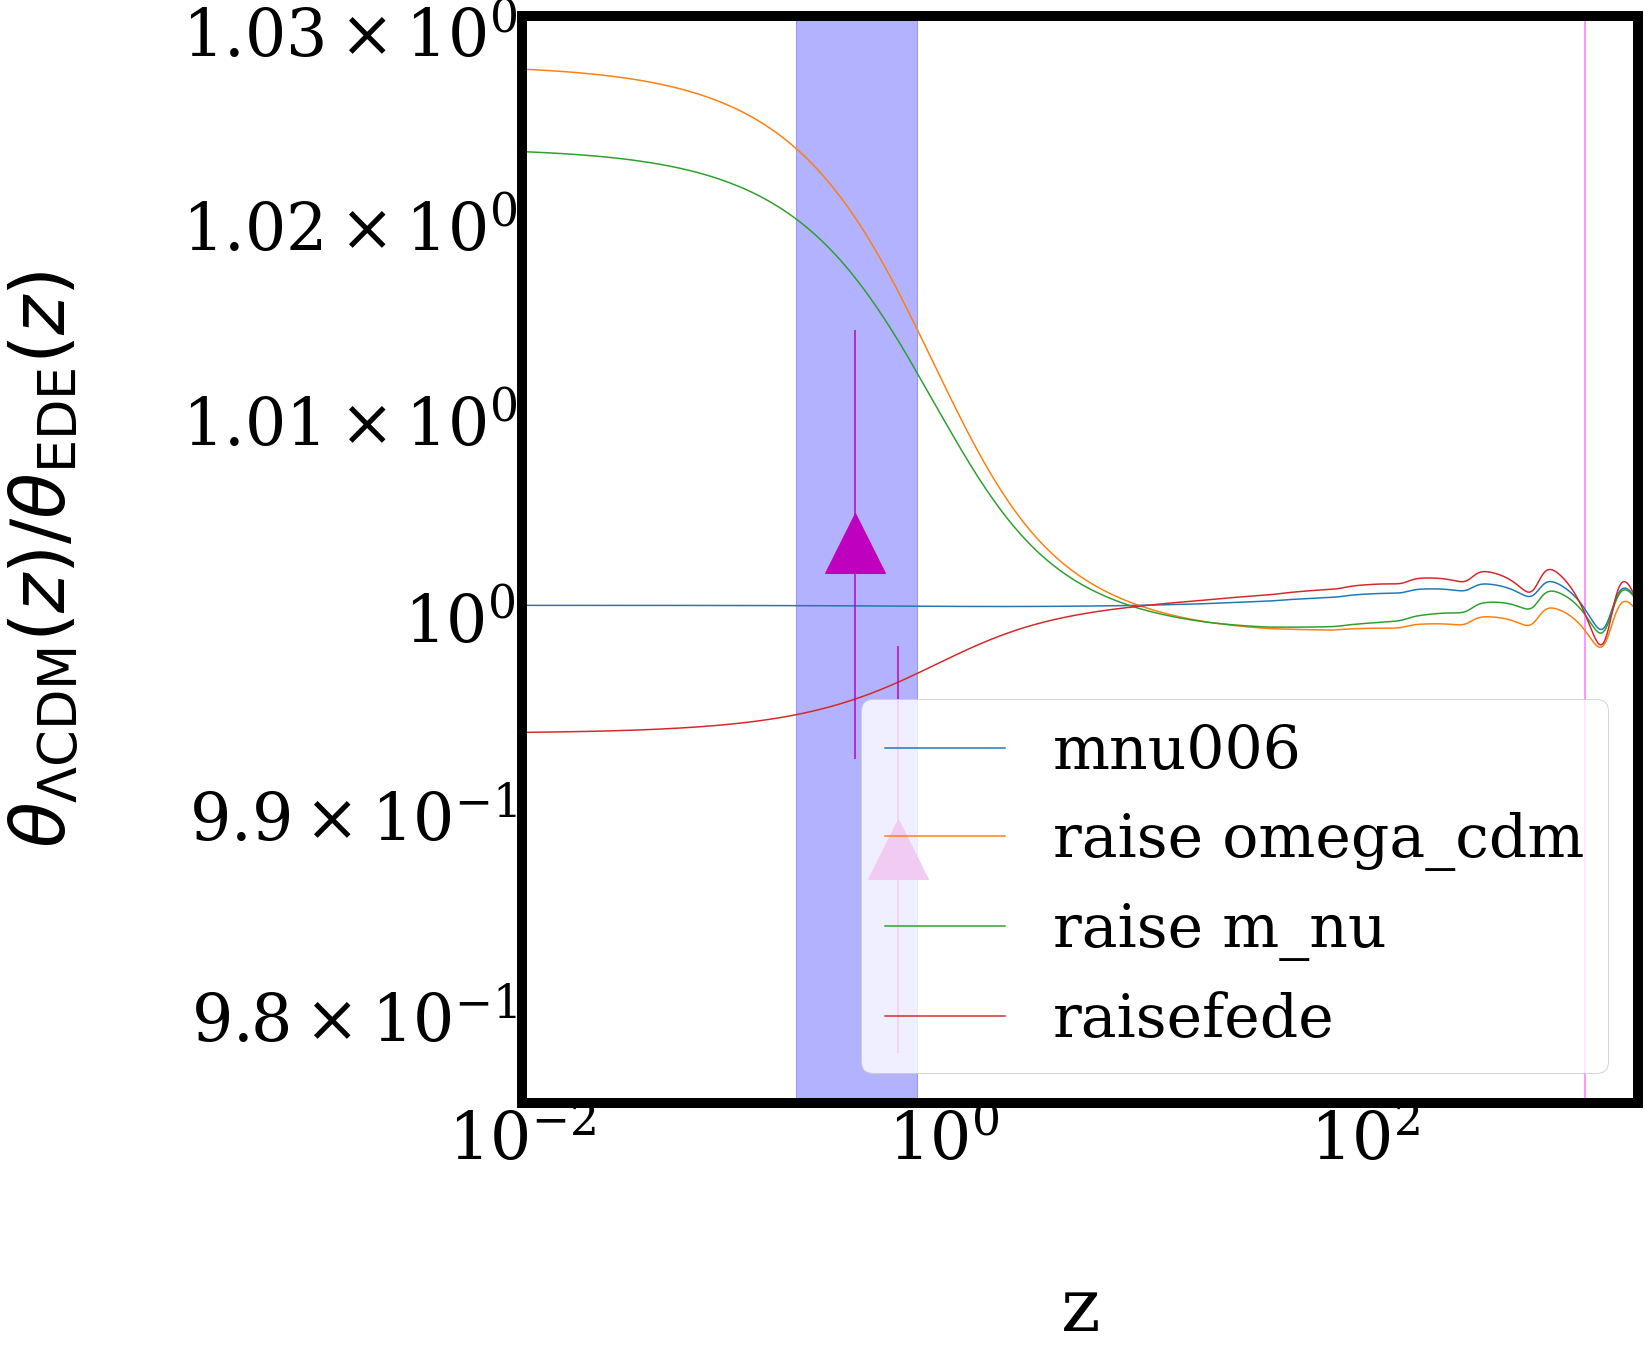

In [35]:
fig, ax = plt.subplots(figsize=(20,20))

matplotlib.rcParams['legend.fontsize'] = 60

ax.loglog(z_lcdm, EDE_pp_out*rs_lcdm/(LCDM_dv), label='mnu006')
ax.loglog(z_lcdm, EDE_mnu024_024bf_out*rs_lcdm/(LCDM_dv),label='raise omega_cdm')
ax.loglog(z_lcdm, EDE_mnu024_006bf_out*rs_lcdm/(LCDM_dv),label='raise m_nu')
ax.loglog(z_lcdm, EDE_mnu024_raisefede_out*rs_lcdm/(LCDM_dv),label='raisefede')


yerr= np.array([(16/rd_fid),(22/rd_fid)])/lcdm_reference_vals #from the error in the alam paper: https://arxiv.org/pdf/1607.03155.pdf eqts 21-23 in sect. 8.2 consensus BAO + fs results

ax.errorbar(boss_zs, boss_ratios, yerr=yerr, fmt='^', color='m', markersize=60)
ax.set_xlim(0.01,2000)
plt.legend()

ax.axvspan(0.2, 0.75, alpha=0.3, color='blue')

ax.axvspan(1100, 1110, alpha=0.3, color='magenta')


ax.set_xlabel('z')
ax.set_ylabel(r'$\theta_{\Lambda{\rm CDM}}(z)/\theta_{\rm EDE}(z)$')

fig.savefig('d_a_evolution_both.pdf', bbox_inches='tight')